In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import os
if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

from scripts.plotting_utils import (
    plot_geog_location, plot_xarray_on_map, 
)

from src.utils import drop_nans_and_flatten

%matplotlib inline

%load_ext autoreload
%autoreload 2


In [3]:
# set data and plot dir
if Path('.').absolute().owner() == 'tommylees':
    data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data')
    plot_dir = Path('/Users/tommylees/Downloads')
else:
    data_dir = Path('data')
    plot_dir = Path('.')  # ???

chirps_path = data_dir / "interim" / "chirps_preprocessed" / "chirps_kenya.nc"
analysis_path = data_dir / "analysis" 
all_indices_path = analysis_path / "indices" / "all_indices_kenya.nc"
vhi_path = data_dir / "interim" / "vhi_preprocessed" / "vhi_kenya.nc"
gleam_path = data_dir / "interim" / "gleam_preprocessed" / "gleam_kenya.nc"
era5_path = data_dir / "interim" / "era5POS_preprocessed" / "era5POS_kenya.nc"
esa_cci_lc_path = data_dir / "interim" / "esa_cci_landcover_preprocessed" / "esa_cci_landcover_kenya.nc"

[d.name for d in (data_dir/'interim' ).iterdir()]

['chirps_preprocessed',
 'era5_land_interim',
 'era5_land_preprocessed',
 'era5POS_preprocessed',
 'esa_cci_landcover_preprocessed',
 'gcloud',
 'gleam_preprocessed',
 'reanalysis-era5-land_preprocessed',
 's5_interim',
 's5_preprocessed',
 'TEMP',
 'vhi_interim',
 'vhi_preprocessed']

In [4]:
ds = xr.open_dataset(esa_cci_lc_path, chunks={'lat':100, 'lon':100})

ds_mask = xr.open_dataset(chirps_path).isel(time=0).isnull().precip.rename('lc_class')

In [6]:
ds

<xarray.Dataset>
Dimensions:   (lat: 4034, lon: 3162, time: 277)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-31 1992-02-29 ... 2015-01-31
  * lat       (lat) float32 6.001389 5.998611 5.9958334 ... -5.1986113 -5.201389
  * lon       (lon) float32 33.50139 33.504166 33.506943 ... 42.279167 42.281944
Data variables:
    lc_class  (time, lat, lon) float32 dask.array<shape=(277, 4034, 3162), chunksize=(277, 100, 100)>

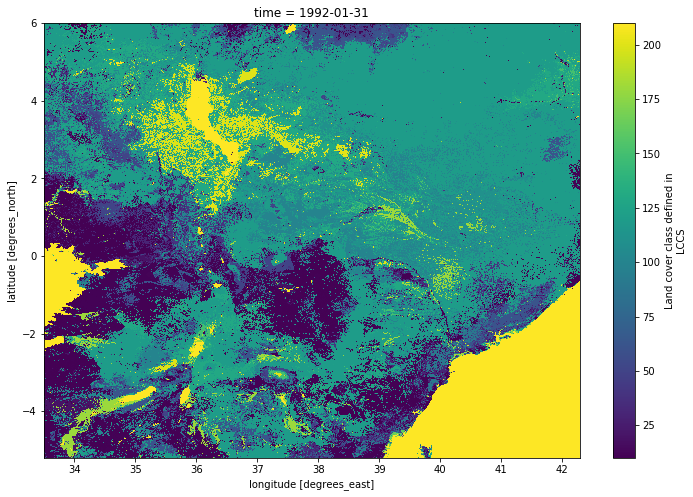

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ds.isel(time=0).lc_class.plot(ax=ax)

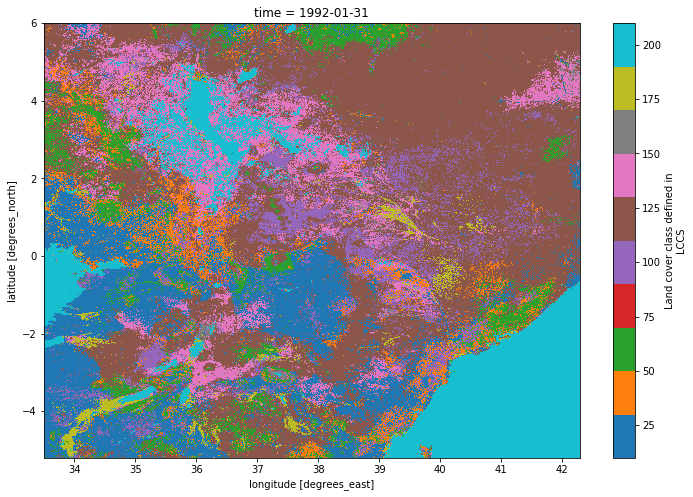

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
ds.isel(time=0).lc_class.plot.pcolormesh(cmap='tab10', ax=ax)

## Plot the cateogircal data with categorical colormap
- [JVP Gist looking at Iris dataset](https://gist.github.com/jakevdp/8a992f606899ac24b711)
- [SO Question about matplotlib and categorical data](https://gis.stackexchange.com/questions/184996/plotting-classification-map-using-shapefile-in-matplotlib)

In [24]:
# get the lookup of the values -> meanings
lookup = dict(zip(ds.lc_class.attrs['flag_values'], (ds.lc_class.attrs['flag_meanings']).split(' ')))
len(lookup.values())

38

In [ ]:
# get the lc data as a numpy array
lc = ds.isel(time=0).lc_class.values

assert lc.shape == (4034, 3162)

valid_vals = ds.lc_class.attrs['flag_values']
actual_vals = np.unique(lc)

In [59]:
fig, ax = plt.subplots(figsize=(12, 8)) 
plt.imshow(lc, cmap=plt.cm.get_cmap('tab10', len(actual_vals)))

# formatter replacing integer values with target names
formatter = plt.FuncFormatter(lambda val, loc: lookup[val])

# We must be sure to specify the ticks matching our target names
plt.colorbar(ticks=actual_vals, format=formatter);

# center the labels?
plt.clim(10, 210)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10fcbdea0> (for post_execute):


KeyError: 130.0

KeyError: 130.0

<Figure size 864x576 with 2 Axes>

In [63]:
# valid_vals = ds.lc_class.attrs['flag_values']
# actual_vals = np.unique(lc)

false_vals = actual_vals[~np.isin(actual_vals, valid_vals)]

actual_vals
display(false_vals)
display(valid_vals)

array([130., 150., 152., 153., 160., 170., 180., 190., 200., 201., 202.,
       210.], dtype=float32)

array([   0,   10,   11,   12,   20,   30,   40,   50,   60,   61,   62,
         70,   71,   72,   80,   81,   82,   90,  100,  110,  120,  121,
        122, -126, -116, -106, -105, -104, -103,  -96,  -86,  -76,  -66,
        -56,  -55,  -54,  -46,  -36], dtype=int8)

In [50]:
from pprint import pprint
print(dir(plt.cm.get_cmap('tab10', 38)))

# plt.cm.get_cmap('tab10', 38)

['N', '__call__', '__class__', '__copy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_i_bad', '_i_over', '_i_under', '_init', '_isinit', '_resample', '_rgba_bad', '_rgba_over', '_rgba_under', '_set_extremes', 'colorbar_extend', 'colors', 'is_gray', 'monochrome', 'name', 'reversed', 'set_bad', 'set_over', 'set_under']


In [ ]:
# use plt.cm.get_cmap(cmap, N) to get an N-bin version of cmap
plt.scatter(iris.data[:, 0], iris.data[:, 1], s=30,
            c=iris.target, cmap=plt.cm.get_cmap('Greens', 3))

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: lookup[val])

# We must be sure to specify the ticks matching our target names
plt.colorbar(ticks=[0, 1, 2], format=formatter);

# Set the clim so that labels are centered on each block
# plt.clim(-0.5, 2.5)

In [23]:
# lookup[k for i, k in enumerate(lookup.values()) if i < 3]

In [ ]:
# # add dict to xarray object
# from scripts.eng_utils import get_lookup_val

# ds_ = get_lookup_val(ds, 'lc_class', 'lc_label', lookup)
# ds_

In [13]:
for area in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='City Area')
# ax.get_legend
fig.colorbar(ax)
# ax.get_legend_handles_labels()

In [ ]:
fig, ax = plt.subplots() # Create a figure with a single axes.
im = ax.imshow(data)     # Display the image data
cbar = fig.colorbar(im)  # Add a colorbar to the figure based on the image